In [1]:
# Train on only MLP part
# Make the hidden layer sparse w/ L1
# No need to normalize decoder weights since we're making those weights sparse anyways

In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
from datasets import Dataset, load_dataset
from tqdm.auto import tqdm
from functools import partial
from einops import rearrange
from huggingface_hub import hf_hub_download
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
from baukit import TraceDict

# Download the model
device = "cuda:0"
model_name="EleutherAI/Pythia-70M-deduped"
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
# set seed
torch.manual_seed(0)
np.random.seed(0)

/root/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from autoencoders import *
# ae_model_id = ["jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.1", "jbrinkma/Pythia-70M-chess_sp51_r4_gpt_neox.layers.2.mlp"]
model_id = "jbrinkma/Pythia-70M-deduped-SAEs"
autoencoders = []
# layers = model.config.num_hidden_layers
layers = 6
cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.attention") for i in range(layers-1)]
# cache_names = [(f"gpt_neox.layers.{i}", f"gpt_neox.layers.{i+1}.mlp") for i in range(1,2)]
num_layers = len(cache_names)
cache_names = [item for sublist in cache_names for item in sublist]
filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-attention-{i+1}.pt") for i in range(layers-1)]
# filenames = [(f"Pythia-70M-deduped-{i}.pt", f"Pythia-70M-deduped-mlp-{i+1}.pt") for i in range(1,2)]
filenames = [item for sublist in filenames for item in sublist]
for filen in filenames:
    ae_download_location = hf_hub_download(repo_id=model_id, filename=filen)
    autoencoder = torch.load(ae_download_location)
    autoencoder.to_device(device)
    # Freeze autoencoder weights
    autoencoder.encoder.requires_grad_(False)
    autoencoder.encoder_bias.requires_grad_(False)
    autoencoders.append(autoencoder)

In [3]:
from activation_dataset import setup_token_data
from utils import dotdict

# Download the dataset
# This formats it, so every datapoint is max_length tokens long
# The batch size is for loading activations from the LLM, not for inference on the autoencoder
cfg = dotdict()
cfg.dataset_name="stas/openwebtext-10k"
cfg.max_length = 256
cfg.model_batch_size = 4
dataset = setup_token_data(cfg, tokenizer, model)
num_tokens = cfg.max_length*cfg.model_batch_size*len(dataset)
print(f"Number of tokens: {num_tokens}")
num_features, d_model = autoencoder.encoder.shape

Found cached dataset openwebtext-10k (/root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b)
Loading cached processed dataset at /root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b/cache-89f7d956ed9de0f6_*_of_00008.arrow


Number of tokens: 11226112


In [4]:
from torch.optim import Adam
from torch import nn  
class sae(nn.Module):
    def __init__(self, input_size, output_size=None):
        super().__init__()
        if(output_size is None):
            output_size = input_size
        self.linear = nn.Linear(input_size, input_size, bias=False)
        self.linear2 = nn.Linear(input_size, output_size, bias=False)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.linear(x)
        x_hidden = self.relu(x)
        x = self.linear2(x_hidden)
        return x, x_hidden

In [5]:
# Load in the features indices
# Note: linear & MLP features are a subet of alive features, not total features
import pickle
with open("linear_features.pkl", "rb") as f:
    linear_features = pickle.load(f)
with open("mlp_features.pkl", "rb") as f:
    mlp_features = pickle.load(f)
with open("alive_features.pkl", "rb") as f:
    alive_features_ind = pickle.load(f)
normalization_per_layer = torch.load("normalization_per_layer.pt")

In [6]:

def train_sparse_model(model, dataset, device, sparse_weights, autoencoders, cache_names, optimizers, l1_alphas, feature_ind, max_batches = 500):
    mse = nn.MSELoss()
    losses = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_mse = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_l1 = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    losses_l1_hidden = [[[] for _ in range(len(l1_alphas))] for _ in range(len(sparse_weights))]
    
    # with dataset.formatted_as("pt"):
    #     dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for i, batch in enumerate(tqdm(dataset)):
        batch = batch["input_ids"].to(device)
        with torch.no_grad():
            with TraceDict(model, cache_names) as ret:
                _ = model(batch)
        
        for cache_name_ind in range(len(cache_names) // 2):
            with torch.no_grad():
                input_cache_name = cache_names[cache_name_ind * 2]
                output_cache_name = cache_names[cache_name_ind * 2 + 1]
                input_autoencoder = autoencoders[cache_name_ind * 2]
                output_autoencoder = autoencoders[cache_name_ind * 2 + 1]
                input_activations = ret[input_cache_name].output
                output_activations = ret[output_cache_name].output

                if isinstance(input_activations, tuple):
                    input_activations = input_activations[0]
                if isinstance(output_activations, tuple):
                    output_activations = output_activations[0]

                input_internal_activations = rearrange(input_activations, "b s n -> (b s) n")
                output_internal_activations = rearrange(output_activations, "b s n -> (b s) n")

                input_internal_activations = input_autoencoder.encode(input_internal_activations)
                output_internal_activations = output_autoencoder.encode(output_internal_activations)

            for l1_alpha_ind, l1_alpha in enumerate(l1_alphas):
                sparse_weight = sparse_weights[cache_name_ind][l1_alpha_ind].to(device)
                x_hat, hidden_act = sparse_weight(input_internal_activations)

                # Find ind of alive features & selected features (linear or MLP features)
                alive_features = alive_features_ind[cache_name_ind].nonzero(as_tuple=True)[0]
                alive_and_selected_features = alive_features[feature_ind[cache_name_ind]].to(device)
                indexed_x_hat = x_hat
                indexed_output_internal_activations = output_internal_activations.index_select(dim=1, index=alive_and_selected_features)
                
                # Divide MSE_loss by normalization factor
                mse_loss = mse(indexed_x_hat, indexed_output_internal_activations) / normalization_per_layer[cache_name_ind]
                l1_loss = torch.norm(sparse_weight.linear.weight, dim=1, p=1).mean()
                # check if sparse_weight.linear2 exists
                if hasattr(sparse_weight, "linear2"):
                    l1_loss += torch.norm(sparse_weight.linear2.weight, dim=1, p=1).mean()
                    l1_loss /= 2
                hidden_loss = torch.norm(hidden_act, 1, dim=-1).mean()
                unweighted_loss = mse_loss + l1_loss + hidden_loss
                loss = mse_loss + l1_alpha * l1_loss + l1_alpha * hidden_loss
                

                loss.backward()
                optimizers[cache_name_ind][l1_alpha_ind].step()
                optimizers[cache_name_ind][l1_alpha_ind].zero_grad()
                losses[cache_name_ind][l1_alpha_ind].append(unweighted_loss.item())
                losses_mse[cache_name_ind][l1_alpha_ind].append(mse_loss.item())
                losses_l1[cache_name_ind][l1_alpha_ind].append(l1_loss.item())
                losses_l1_hidden[cache_name_ind][l1_alpha_ind].append(hidden_loss.item())

                sparse_weight = sparse_weight.to("cpu")
                if i % 100 == 0:
                    sparsity = (hidden_act != 0).float().mean(dim=0).sum().cpu().item()
                    print(f"Layers: {cache_name_ind} | l1 alpha MSE Loss: {mse_loss.item():.4f} | L1 Loss: {l1_loss.item():.2f} | Hidden Loss: {hidden_loss.item():.2f}  L0: {sparsity:.0f}")

                del x_hat, indexed_x_hat, indexed_output_internal_activations, loss, l1_loss, mse_loss, unweighted_loss, alive_and_selected_features
                torch.cuda.empty_cache()
        if i > max_batches:
            # Stop training after 1000 batches
            break
    return losses, losses_mse, losses_l1, losses_l1_hidden


In [7]:
# Let's just think about this for 1 layer
# If we're doing 10-different l1 alpha terms, then we have 10 different sparse weights
mlp_weights_no_bias = []
# l1_alphas = [1e-5, 4e-5, 7e-5, 1e-4, 4e-4, 7e-4, 1e-3, 4e-3, 7e-3, 1e-2]
l1_alphas = [4e-4]

mlp_optimizers_no_bias = []
l1_alpha = len(l1_alphas)
for layer in range(num_layers): # This is per layer
    num_linear_features = linear_features[layer].sum()
    num_mlp_features = mlp_features[layer].sum()
    mlp_weights_no_bias.append([])
    mlp_optimizers_no_bias.append([])
    for l1_alpha_ind in range(l1_alpha):
        mlp_weights_no_bias[-1].append(sae(num_features, output_size=num_mlp_features))
        mlp_optimizers_no_bias[-1].append(Adam(mlp_weights_no_bias[-1][-1].parameters(), lr=1e-3))
max_batches = 3000
mlp_losses_no_bias, mlp_losses_no_bias_mse, mlp_losses_no_bias_l1, mlp_losses_no_bias_l1_hidden = train_sparse_model(model, dataset, device, mlp_weights_no_bias, autoencoders, cache_names, mlp_optimizers_no_bias, l1_alphas, mlp_features, max_batches=max_batches)

  0%|          | 0/10963 [00:00<?, ?it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0120 | L1 Loss: 27.72 | Hidden Loss: 56.12  L0: 1536
Layers: 1 | l1 alpha MSE Loss: 0.5441 | L1 Loss: 27.73 | Hidden Loss: 65.02  L0: 1530
Layers: 2 | l1 alpha MSE Loss: 0.1212 | L1 Loss: 27.69 | Hidden Loss: 89.69  L0: 1533


  0%|          | 1/10963 [00:00<2:38:08,  1.16it/s]

Layers: 3 | l1 alpha MSE Loss: 0.1912 | L1 Loss: 27.70 | Hidden Loss: 111.81  L0: 1548
Layers: 4 | l1 alpha MSE Loss: 1.6684 | L1 Loss: 27.73 | Hidden Loss: 113.56  L0: 1532


  1%|          | 101/10963 [00:32<51:43,  3.50it/s] 

Layers: 0 | l1 alpha MSE Loss: 0.0067 | L1 Loss: 1.37 | Hidden Loss: 1.08  L0: 34
Layers: 1 | l1 alpha MSE Loss: 0.0590 | L1 Loss: 20.76 | Hidden Loss: 25.37  L0: 349
Layers: 2 | l1 alpha MSE Loss: 0.0139 | L1 Loss: 13.30 | Hidden Loss: 29.41  L0: 251
Layers: 3 | l1 alpha MSE Loss: 0.0121 | L1 Loss: 12.30 | Hidden Loss: 49.32  L0: 254
Layers: 4 | l1 alpha MSE Loss: 0.0567 | L1 Loss: 21.55 | Hidden Loss: 644.89  L0: 1306


  2%|▏         | 201/10963 [01:01<55:59,  3.20it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0073 | L1 Loss: 1.39 | Hidden Loss: 1.24  L0: 33
Layers: 1 | l1 alpha MSE Loss: 0.0242 | L1 Loss: 19.36 | Hidden Loss: 19.00  L0: 233
Layers: 2 | l1 alpha MSE Loss: 0.0108 | L1 Loss: 11.09 | Hidden Loss: 19.08  L0: 117
Layers: 3 | l1 alpha MSE Loss: 0.0101 | L1 Loss: 10.82 | Hidden Loss: 28.51  L0: 118
Layers: 4 | l1 alpha MSE Loss: 0.0330 | L1 Loss: 20.90 | Hidden Loss: 413.53  L0: 1108


  3%|▎         | 301/10963 [01:32<47:43,  3.72it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0054 | L1 Loss: 1.47 | Hidden Loss: 1.06  L0: 48
Layers: 1 | l1 alpha MSE Loss: 0.0308 | L1 Loss: 18.13 | Hidden Loss: 16.44  L0: 184
Layers: 2 | l1 alpha MSE Loss: 0.0116 | L1 Loss: 9.59 | Hidden Loss: 13.25  L0: 83
Layers: 3 | l1 alpha MSE Loss: 0.0083 | L1 Loss: 9.49 | Hidden Loss: 18.06  L0: 65
Layers: 4 | l1 alpha MSE Loss: 0.0846 | L1 Loss: 20.12 | Hidden Loss: 144.86  L0: 467


  4%|▎         | 400/10963 [02:03<53:52,  3.27it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0070 | L1 Loss: 1.50 | Hidden Loss: 1.21  L0: 25
Layers: 1 | l1 alpha MSE Loss: 0.0154 | L1 Loss: 17.28 | Hidden Loss: 15.62  L0: 125
Layers: 2 | l1 alpha MSE Loss: 0.0085 | L1 Loss: 8.61 | Hidden Loss: 11.89  L0: 55
Layers: 3 | l1 alpha MSE Loss: 0.0074 | L1 Loss: 8.61 | Hidden Loss: 17.17  L0: 51


  4%|▎         | 401/10963 [02:03<56:40,  3.11it/s]

Layers: 4 | l1 alpha MSE Loss: 0.0226 | L1 Loss: 18.58 | Hidden Loss: 120.87  L0: 274


  5%|▍         | 500/10963 [02:33<50:04,  3.48it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0058 | L1 Loss: 1.53 | Hidden Loss: 1.25  L0: 31
Layers: 1 | l1 alpha MSE Loss: 0.0199 | L1 Loss: 16.88 | Hidden Loss: 14.06  L0: 118
Layers: 2 | l1 alpha MSE Loss: 0.0090 | L1 Loss: 7.90 | Hidden Loss: 10.52  L0: 48
Layers: 3 | l1 alpha MSE Loss: 0.0083 | L1 Loss: 7.97 | Hidden Loss: 15.38  L0: 46


  5%|▍         | 501/10963 [02:34<50:35,  3.45it/s]

Layers: 4 | l1 alpha MSE Loss: 0.0276 | L1 Loss: 17.25 | Hidden Loss: 108.11  L0: 190


  5%|▌         | 600/10963 [03:03<51:43,  3.34it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0060 | L1 Loss: 1.57 | Hidden Loss: 0.94  L0: 53
Layers: 1 | l1 alpha MSE Loss: 0.0259 | L1 Loss: 16.26 | Hidden Loss: 12.52  L0: 113
Layers: 2 | l1 alpha MSE Loss: 0.0118 | L1 Loss: 7.32 | Hidden Loss: 10.28  L0: 50
Layers: 3 | l1 alpha MSE Loss: 0.0064 | L1 Loss: 7.50 | Hidden Loss: 11.98  L0: 35


  5%|▌         | 601/10963 [03:03<51:47,  3.33it/s]

Layers: 4 | l1 alpha MSE Loss: 0.0265 | L1 Loss: 16.29 | Hidden Loss: 88.48  L0: 178


  6%|▋         | 701/10963 [03:32<41:58,  4.07it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0055 | L1 Loss: 1.60 | Hidden Loss: 0.84  L0: 30
Layers: 1 | l1 alpha MSE Loss: 0.0173 | L1 Loss: 15.86 | Hidden Loss: 11.19  L0: 82
Layers: 2 | l1 alpha MSE Loss: 0.0086 | L1 Loss: 6.86 | Hidden Loss: 7.67  L0: 33
Layers: 3 | l1 alpha MSE Loss: 0.0065 | L1 Loss: 7.14 | Hidden Loss: 11.46  L0: 30
Layers: 4 | l1 alpha MSE Loss: 0.0319 | L1 Loss: 15.49 | Hidden Loss: 77.15  L0: 68


  7%|▋         | 801/10963 [04:00<46:02,  3.68it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0059 | L1 Loss: 1.58 | Hidden Loss: 1.04  L0: 32
Layers: 1 | l1 alpha MSE Loss: 0.0267 | L1 Loss: 15.35 | Hidden Loss: 12.25  L0: 87
Layers: 2 | l1 alpha MSE Loss: 0.0089 | L1 Loss: 6.46 | Hidden Loss: 8.47  L0: 33
Layers: 3 | l1 alpha MSE Loss: 0.0060 | L1 Loss: 6.73 | Hidden Loss: 11.30  L0: 29
Layers: 4 | l1 alpha MSE Loss: 0.0193 | L1 Loss: 14.76 | Hidden Loss: 78.10  L0: 84


  8%|▊         | 900/10963 [04:27<46:04,  3.64it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0064 | L1 Loss: 1.64 | Hidden Loss: 1.06  L0: 35
Layers: 1 | l1 alpha MSE Loss: 0.0185 | L1 Loss: 15.07 | Hidden Loss: 9.87  L0: 70
Layers: 2 | l1 alpha MSE Loss: 0.0078 | L1 Loss: 6.17 | Hidden Loss: 6.72  L0: 28
Layers: 3 | l1 alpha MSE Loss: 0.0065 | L1 Loss: 6.46 | Hidden Loss: 10.44  L0: 29


  8%|▊         | 901/10963 [04:27<46:55,  3.57it/s]

Layers: 4 | l1 alpha MSE Loss: 0.0290 | L1 Loss: 14.30 | Hidden Loss: 78.05  L0: 94


  9%|▉         | 1000/10963 [04:57<49:16,  3.37it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0065 | L1 Loss: 1.63 | Hidden Loss: 0.93  L0: 34
Layers: 1 | l1 alpha MSE Loss: 0.0174 | L1 Loss: 14.95 | Hidden Loss: 10.64  L0: 76
Layers: 2 | l1 alpha MSE Loss: 0.0082 | L1 Loss: 5.91 | Hidden Loss: 7.68  L0: 29
Layers: 3 | l1 alpha MSE Loss: 0.0055 | L1 Loss: 6.23 | Hidden Loss: 10.30  L0: 25


  9%|▉         | 1001/10963 [04:58<48:50,  3.40it/s]

Layers: 4 | l1 alpha MSE Loss: 0.0176 | L1 Loss: 13.90 | Hidden Loss: 69.39  L0: 54


 10%|█         | 1101/10963 [05:28<47:01,  3.50it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0056 | L1 Loss: 1.65 | Hidden Loss: 0.89  L0: 32
Layers: 1 | l1 alpha MSE Loss: 0.0121 | L1 Loss: 14.48 | Hidden Loss: 10.82  L0: 58
Layers: 2 | l1 alpha MSE Loss: 0.0079 | L1 Loss: 5.70 | Hidden Loss: 6.71  L0: 25
Layers: 3 | l1 alpha MSE Loss: 0.0060 | L1 Loss: 6.03 | Hidden Loss: 9.79  L0: 25
Layers: 4 | l1 alpha MSE Loss: 0.0198 | L1 Loss: 13.62 | Hidden Loss: 67.04  L0: 54


 11%|█         | 1200/10963 [05:56<43:36,  3.73it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0059 | L1 Loss: 1.68 | Hidden Loss: 0.90  L0: 36
Layers: 1 | l1 alpha MSE Loss: 0.0181 | L1 Loss: 14.24 | Hidden Loss: 9.32  L0: 56
Layers: 2 | l1 alpha MSE Loss: 0.0072 | L1 Loss: 5.51 | Hidden Loss: 6.74  L0: 24
Layers: 3 | l1 alpha MSE Loss: 0.0059 | L1 Loss: 5.78 | Hidden Loss: 8.97  L0: 23


 11%|█         | 1201/10963 [05:57<44:13,  3.68it/s]

Layers: 4 | l1 alpha MSE Loss: 0.0228 | L1 Loss: 13.28 | Hidden Loss: 63.72  L0: 63


 12%|█▏        | 1301/10963 [06:25<46:20,  3.47it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0062 | L1 Loss: 1.71 | Hidden Loss: 0.88  L0: 29
Layers: 1 | l1 alpha MSE Loss: 0.0130 | L1 Loss: 14.00 | Hidden Loss: 9.35  L0: 52
Layers: 2 | l1 alpha MSE Loss: 0.0074 | L1 Loss: 5.34 | Hidden Loss: 5.74  L0: 21
Layers: 3 | l1 alpha MSE Loss: 0.0059 | L1 Loss: 5.60 | Hidden Loss: 8.73  L0: 22
Layers: 4 | l1 alpha MSE Loss: 0.0287 | L1 Loss: 12.99 | Hidden Loss: 60.30  L0: 72


 13%|█▎        | 1401/10963 [06:53<44:57,  3.54it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0057 | L1 Loss: 1.71 | Hidden Loss: 0.85  L0: 33
Layers: 1 | l1 alpha MSE Loss: 0.0178 | L1 Loss: 13.77 | Hidden Loss: 9.21  L0: 48
Layers: 2 | l1 alpha MSE Loss: 0.0094 | L1 Loss: 5.19 | Hidden Loss: 6.36  L0: 23
Layers: 3 | l1 alpha MSE Loss: 0.0057 | L1 Loss: 5.40 | Hidden Loss: 8.59  L0: 22
Layers: 4 | l1 alpha MSE Loss: 0.0174 | L1 Loss: 12.72 | Hidden Loss: 58.69  L0: 52


 14%|█▎        | 1501/10963 [07:23<43:42,  3.61it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0062 | L1 Loss: 1.75 | Hidden Loss: 0.88  L0: 31
Layers: 1 | l1 alpha MSE Loss: 0.0233 | L1 Loss: 13.72 | Hidden Loss: 9.45  L0: 48
Layers: 2 | l1 alpha MSE Loss: 0.0081 | L1 Loss: 5.07 | Hidden Loss: 5.47  L0: 20
Layers: 3 | l1 alpha MSE Loss: 0.0058 | L1 Loss: 5.26 | Hidden Loss: 8.67  L0: 21
Layers: 4 | l1 alpha MSE Loss: 0.0208 | L1 Loss: 12.55 | Hidden Loss: 57.84  L0: 48


 15%|█▍        | 1600/10963 [07:50<42:17,  3.69it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0053 | L1 Loss: 1.74 | Hidden Loss: 1.02  L0: 37
Layers: 1 | l1 alpha MSE Loss: 0.0130 | L1 Loss: 13.57 | Hidden Loss: 8.58  L0: 42
Layers: 2 | l1 alpha MSE Loss: 0.0079 | L1 Loss: 4.95 | Hidden Loss: 5.37  L0: 19
Layers: 3 | l1 alpha MSE Loss: 0.0057 | L1 Loss: 5.10 | Hidden Loss: 7.83  L0: 20


 15%|█▍        | 1601/10963 [07:50<42:54,  3.64it/s]

Layers: 4 | l1 alpha MSE Loss: 0.0213 | L1 Loss: 12.31 | Hidden Loss: 54.39  L0: 50


 16%|█▌        | 1701/10963 [08:17<42:34,  3.63it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0063 | L1 Loss: 1.73 | Hidden Loss: 0.89  L0: 28
Layers: 1 | l1 alpha MSE Loss: 0.0116 | L1 Loss: 13.37 | Hidden Loss: 9.32  L0: 46
Layers: 2 | l1 alpha MSE Loss: 0.0081 | L1 Loss: 4.83 | Hidden Loss: 5.51  L0: 19
Layers: 3 | l1 alpha MSE Loss: 0.0075 | L1 Loss: 4.96 | Hidden Loss: 8.33  L0: 21
Layers: 4 | l1 alpha MSE Loss: 0.0265 | L1 Loss: 12.11 | Hidden Loss: 56.31  L0: 43


 16%|█▋        | 1800/10963 [08:47<51:58,  2.94it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0053 | L1 Loss: 1.73 | Hidden Loss: 0.84  L0: 38
Layers: 1 | l1 alpha MSE Loss: 0.0155 | L1 Loss: 13.36 | Hidden Loss: 7.97  L0: 54
Layers: 2 | l1 alpha MSE Loss: 0.0078 | L1 Loss: 4.75 | Hidden Loss: 5.51  L0: 21


 16%|█▋        | 1801/10963 [08:48<52:40,  2.90it/s]

Layers: 3 | l1 alpha MSE Loss: 0.0066 | L1 Loss: 4.84 | Hidden Loss: 7.76  L0: 20
Layers: 4 | l1 alpha MSE Loss: 0.0175 | L1 Loss: 11.95 | Hidden Loss: 49.85  L0: 38


 17%|█▋        | 1900/10963 [09:20<50:27,  2.99it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0053 | L1 Loss: 1.74 | Hidden Loss: 0.69  L0: 55
Layers: 1 | l1 alpha MSE Loss: 0.0153 | L1 Loss: 13.08 | Hidden Loss: 7.73  L0: 51
Layers: 2 | l1 alpha MSE Loss: 0.0077 | L1 Loss: 4.66 | Hidden Loss: 4.74  L0: 18
Layers: 3 | l1 alpha MSE Loss: 0.0064 | L1 Loss: 4.75 | Hidden Loss: 6.79  L0: 21


 17%|█▋        | 1901/10963 [09:20<48:18,  3.13it/s]

Layers: 4 | l1 alpha MSE Loss: 0.0213 | L1 Loss: 11.75 | Hidden Loss: 47.41  L0: 49


 18%|█▊        | 2000/10963 [09:49<41:42,  3.58it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0055 | L1 Loss: 1.77 | Hidden Loss: 0.86  L0: 28
Layers: 1 | l1 alpha MSE Loss: 0.0187 | L1 Loss: 12.82 | Hidden Loss: 8.50  L0: 47
Layers: 2 | l1 alpha MSE Loss: 0.0089 | L1 Loss: 4.58 | Hidden Loss: 5.51  L0: 19
Layers: 3 | l1 alpha MSE Loss: 0.0055 | L1 Loss: 4.64 | Hidden Loss: 7.77  L0: 18
Layers: 4 | l1 alpha MSE Loss: 0.0167 | L1 Loss: 11.55 | Hidden Loss: 51.18  L0: 37


 19%|█▉        | 2101/10963 [10:18<43:42,  3.38it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0054 | L1 Loss: 1.74 | Hidden Loss: 0.74  L0: 31
Layers: 1 | l1 alpha MSE Loss: 0.0132 | L1 Loss: 12.53 | Hidden Loss: 7.83  L0: 40
Layers: 2 | l1 alpha MSE Loss: 0.0073 | L1 Loss: 4.52 | Hidden Loss: 5.22  L0: 18
Layers: 3 | l1 alpha MSE Loss: 0.0059 | L1 Loss: 4.54 | Hidden Loss: 7.41  L0: 18
Layers: 4 | l1 alpha MSE Loss: 0.0160 | L1 Loss: 11.39 | Hidden Loss: 49.64  L0: 37


 20%|██        | 2200/10963 [10:50<40:29,  3.61it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0057 | L1 Loss: 1.76 | Hidden Loss: 0.80  L0: 30
Layers: 1 | l1 alpha MSE Loss: 0.0146 | L1 Loss: 12.39 | Hidden Loss: 8.17  L0: 32
Layers: 2 | l1 alpha MSE Loss: 0.0078 | L1 Loss: 4.46 | Hidden Loss: 4.90  L0: 17
Layers: 3 | l1 alpha MSE Loss: 0.0057 | L1 Loss: 4.46 | Hidden Loss: 7.17  L0: 18


 20%|██        | 2201/10963 [10:50<41:33,  3.51it/s]

Layers: 4 | l1 alpha MSE Loss: 0.0176 | L1 Loss: 11.19 | Hidden Loss: 46.84  L0: 41


 21%|██        | 2301/10963 [11:21<39:29,  3.66it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0063 | L1 Loss: 1.79 | Hidden Loss: 0.77  L0: 34
Layers: 1 | l1 alpha MSE Loss: 0.0146 | L1 Loss: 12.11 | Hidden Loss: 8.03  L0: 43
Layers: 2 | l1 alpha MSE Loss: 0.0083 | L1 Loss: 4.41 | Hidden Loss: 5.37  L0: 19
Layers: 3 | l1 alpha MSE Loss: 0.0053 | L1 Loss: 4.38 | Hidden Loss: 7.06  L0: 17
Layers: 4 | l1 alpha MSE Loss: 0.0176 | L1 Loss: 11.00 | Hidden Loss: 47.23  L0: 40


 22%|██▏       | 2400/10963 [11:50<39:44,  3.59it/s]  

Layers: 0 | l1 alpha MSE Loss: 0.0056 | L1 Loss: 1.77 | Hidden Loss: 0.84  L0: 43
Layers: 1 | l1 alpha MSE Loss: 0.0147 | L1 Loss: 12.06 | Hidden Loss: 8.12  L0: 37
Layers: 2 | l1 alpha MSE Loss: 0.0076 | L1 Loss: 4.37 | Hidden Loss: 5.29  L0: 17
Layers: 3 | l1 alpha MSE Loss: 0.0055 | L1 Loss: 4.30 | Hidden Loss: 6.69  L0: 17


 22%|██▏       | 2401/10963 [11:50<39:34,  3.61it/s]

Layers: 4 | l1 alpha MSE Loss: 0.0166 | L1 Loss: 10.85 | Hidden Loss: 41.12  L0: 34


 23%|██▎       | 2500/10963 [12:20<42:39,  3.31it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0051 | L1 Loss: 1.80 | Hidden Loss: 0.77  L0: 32
Layers: 1 | l1 alpha MSE Loss: 0.0223 | L1 Loss: 11.80 | Hidden Loss: 8.06  L0: 36
Layers: 2 | l1 alpha MSE Loss: 0.0085 | L1 Loss: 4.30 | Hidden Loss: 5.62  L0: 17
Layers: 3 | l1 alpha MSE Loss: 0.0058 | L1 Loss: 4.24 | Hidden Loss: 7.33  L0: 17


 23%|██▎       | 2501/10963 [12:20<44:38,  3.16it/s]

Layers: 4 | l1 alpha MSE Loss: 0.0151 | L1 Loss: 10.71 | Hidden Loss: 46.76  L0: 33


 24%|██▎       | 2600/10963 [12:52<39:48,  3.50it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0047 | L1 Loss: 1.80 | Hidden Loss: 0.85  L0: 32
Layers: 1 | l1 alpha MSE Loss: 0.0112 | L1 Loss: 11.72 | Hidden Loss: 7.73  L0: 33
Layers: 2 | l1 alpha MSE Loss: 0.0081 | L1 Loss: 4.26 | Hidden Loss: 4.68  L0: 16
Layers: 3 | l1 alpha MSE Loss: 0.0063 | L1 Loss: 4.16 | Hidden Loss: 6.69  L0: 17
Layers: 4 | l1 alpha MSE Loss: 0.0210 | L1 Loss: 10.53 | Hidden Loss: 42.11  L0: 34


 25%|██▍       | 2700/10963 [13:20<36:44,  3.75it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0052 | L1 Loss: 1.84 | Hidden Loss: 0.83  L0: 38
Layers: 1 | l1 alpha MSE Loss: 0.0168 | L1 Loss: 11.51 | Hidden Loss: 7.14  L0: 32
Layers: 2 | l1 alpha MSE Loss: 0.0073 | L1 Loss: 4.23 | Hidden Loss: 4.85  L0: 17
Layers: 3 | l1 alpha MSE Loss: 0.0064 | L1 Loss: 4.13 | Hidden Loss: 6.76  L0: 17
Layers: 4 | l1 alpha MSE Loss: 0.0169 | L1 Loss: 10.38 | Hidden Loss: 42.32  L0: 33


 26%|██▌       | 2800/10963 [13:50<41:02,  3.31it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0060 | L1 Loss: 1.76 | Hidden Loss: 0.80  L0: 33
Layers: 1 | l1 alpha MSE Loss: 0.0167 | L1 Loss: 11.44 | Hidden Loss: 7.01  L0: 32
Layers: 2 | l1 alpha MSE Loss: 0.0067 | L1 Loss: 4.19 | Hidden Loss: 4.39  L0: 15
Layers: 3 | l1 alpha MSE Loss: 0.0052 | L1 Loss: 4.06 | Hidden Loss: 6.18  L0: 16


 26%|██▌       | 2801/10963 [13:50<41:15,  3.30it/s]

Layers: 4 | l1 alpha MSE Loss: 0.0167 | L1 Loss: 10.18 | Hidden Loss: 39.76  L0: 32


 26%|██▋       | 2900/10963 [14:20<38:00,  3.53it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0042 | L1 Loss: 1.75 | Hidden Loss: 0.85  L0: 34
Layers: 1 | l1 alpha MSE Loss: 0.0101 | L1 Loss: 11.29 | Hidden Loss: 7.06  L0: 29
Layers: 2 | l1 alpha MSE Loss: 0.0075 | L1 Loss: 4.16 | Hidden Loss: 4.35  L0: 15
Layers: 3 | l1 alpha MSE Loss: 0.0056 | L1 Loss: 4.02 | Hidden Loss: 5.94  L0: 15
Layers: 4 | l1 alpha MSE Loss: 0.0157 | L1 Loss: 10.05 | Hidden Loss: 38.87  L0: 32


 27%|██▋       | 3000/10963 [14:53<45:16,  2.93it/s]

Layers: 0 | l1 alpha MSE Loss: 0.0052 | L1 Loss: 1.81 | Hidden Loss: 0.86  L0: 27
Layers: 1 | l1 alpha MSE Loss: 0.0119 | L1 Loss: 10.90 | Hidden Loss: 6.95  L0: 26
Layers: 2 | l1 alpha MSE Loss: 0.0073 | L1 Loss: 4.14 | Hidden Loss: 4.10  L0: 14
Layers: 3 | l1 alpha MSE Loss: 0.0073 | L1 Loss: 3.97 | Hidden Loss: 5.85  L0: 15


 27%|██▋       | 3001/10963 [14:54<43:54,  3.02it/s]

Layers: 4 | l1 alpha MSE Loss: 0.0514 | L1 Loss: 9.87 | Hidden Loss: 38.25  L0: 34


 27%|██▋       | 3001/10963 [14:54<39:32,  3.36it/s]


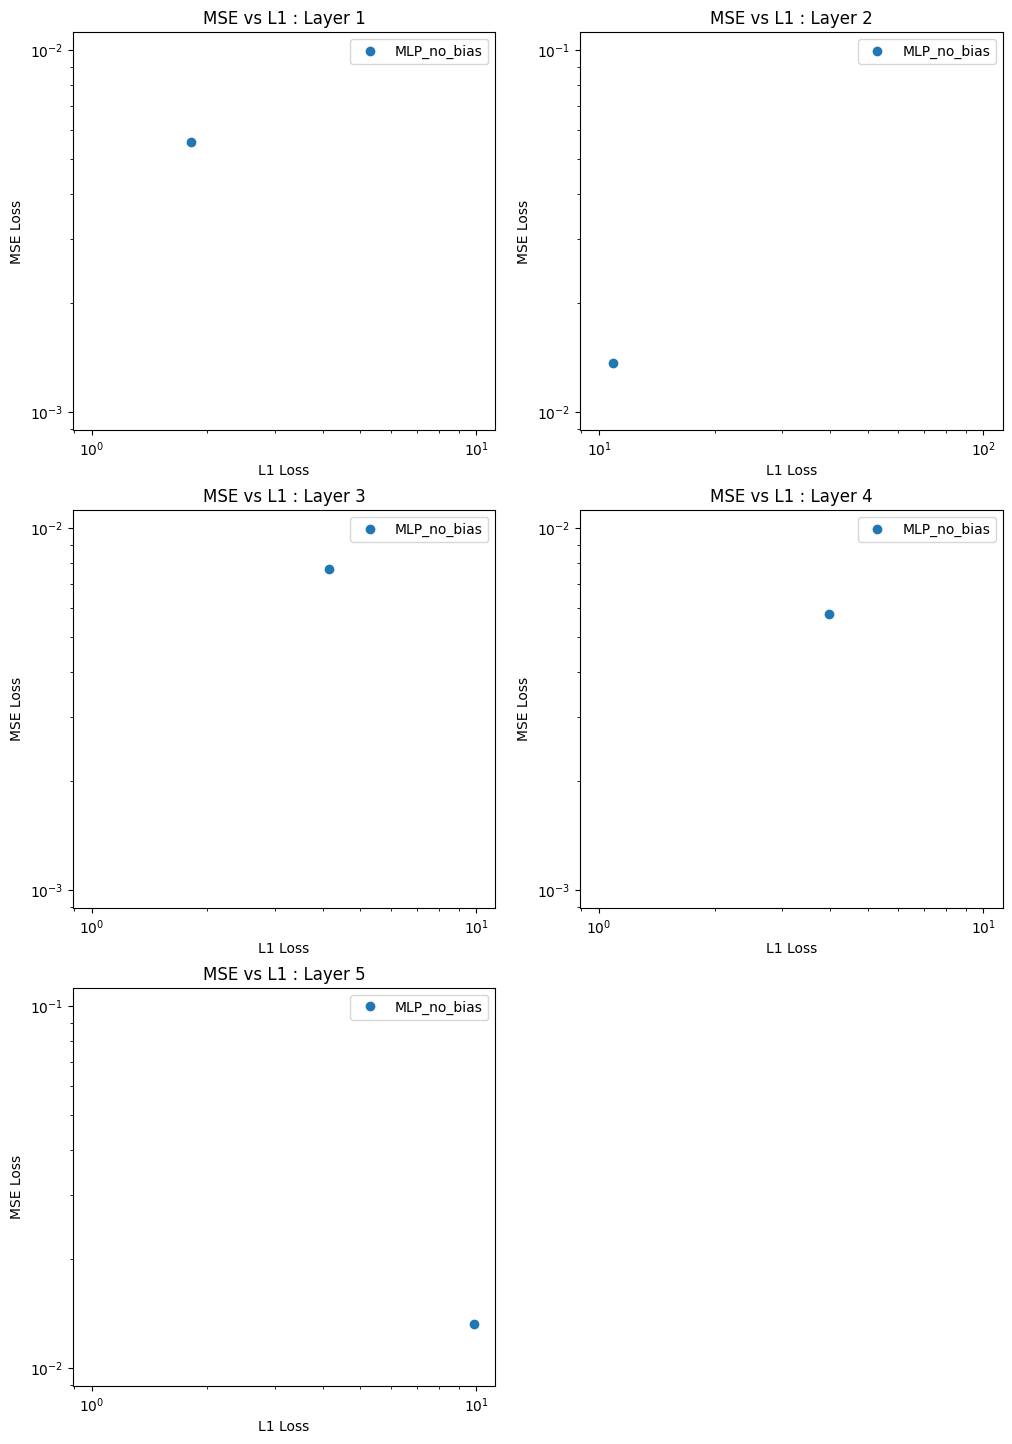

In [8]:
# Plot both losses, just the last value for both MSE and L1
import matplotlib.pyplot as plt
# mlp_losses_no_bias, mlp_losses_no_bias_mse, mlp_losses_no_bias_l1, mlp_losses_no_bias_l1_hidden
num_layers = len(mlp_losses_no_bias)
num_columns = 2  # Two columns: one for each type of loss
num_rows = num_layers  # One row for each layer

l1_alpha_num = len(l1_alphas)
mlp_mse_losses_last = np.zeros((num_layers, l1_alpha_num))
mlp_l1_losses_last = np.zeros((num_layers, l1_alpha_num))
mlp_l1_hidden_losses_last = np.zeros((num_layers, l1_alpha_num))
for layer in range(num_layers):
    for l1_alpha_ind, l1_alpha in enumerate(l1_alphas):
        mlp_mse_losses_last[layer, l1_alpha_ind] = mlp_losses_no_bias_mse[layer][l1_alpha_ind][-1]
        mlp_l1_losses_last[layer, l1_alpha_ind] = mlp_losses_no_bias_l1[layer][l1_alpha_ind][-1]
        mlp_l1_hidden_losses_last[layer, l1_alpha_ind] = mlp_losses_no_bias_l1_hidden[layer][l1_alpha_ind][-1]

plt.figure(figsize=(12, 6 * num_rows))  # Adjust the size as needed

for layer in range(num_layers):
    # Subplot for MSE Loss
    plt.subplot(num_rows, num_columns, layer+1)
    plt.title(f"MSE vs L1 : Layer {layer+1}")
    # Grabe the last value of MSE and L1
    mlp_l1_loss = mlp_l1_losses_last[layer] 
    mlp_mse_loss = mlp_mse_losses_last[layer] 
    mlp_l1_hidden_loss = mlp_l1_hidden_losses_last[layer]
    # Plot
    plt.plot(mlp_l1_loss, mlp_mse_loss, 'o', label="MLP_no_bias")
    plt.xlabel("L1 Loss")
    plt.ylabel("MSE Loss")
    # put both on logplot
    plt.yscale('log')
    plt.xscale('log')
    plt.legend()
plt.show()

In [9]:
# Save these mlp weights
dir = "sparse_weights"
for layer in range(num_layers):
    for l1_alpha_ind, l1_alpha in enumerate(l1_alphas):
        torch.save(mlp_weights_no_bias[layer][l1_alpha_ind], f"{dir}/Pythia-70M-deduped-mlp-{layer+1}-l1_alpha-{l1_alpha}.pt")

In [23]:
for l1_alpha, mse, l1, hidden in zip(l1_alphas, mlp_mse_loss, mlp_l1_loss, mlp_l1_hidden_loss):
    print(f"l1_alpha: {l1_alpha:.1E} | MSE: {mse:.1E} | L1: {l1:.1f} | Hidden: {hidden:.2f}")

l1_alpha: 1.0E-05 | MSE: 1.8E-03 | L1: 28.6 | Hidden: 11.76
l1_alpha: 4.0E-05 | MSE: 1.9E-03 | L1: 13.2 | Hidden: 5.45
l1_alpha: 7.0E-05 | MSE: 2.0E-03 | L1: 9.2 | Hidden: 3.90
l1_alpha: 1.0E-04 | MSE: 2.0E-03 | L1: 7.3 | Hidden: 3.16
l1_alpha: 4.0E-04 | MSE: 5.7E-03 | L1: 1.8 | Hidden: 0.81
l1_alpha: 7.0E-04 | MSE: 7.5E-03 | L1: 1.2 | Hidden: 0.35
l1_alpha: 1.0E-03 | MSE: 8.3E-03 | L1: 1.0 | Hidden: 0.23
l1_alpha: 4.0E-03 | MSE: 1.3E-02 | L1: 0.8 | Hidden: 0.02
l1_alpha: 7.0E-03 | MSE: 1.3E-02 | L1: 0.8 | Hidden: 0.02
l1_alpha: 1.0E-02 | MSE: 1.3E-02 | L1: 0.8 | Hidden: 0.02


Text(0, 0.5, 'l1_hidden')

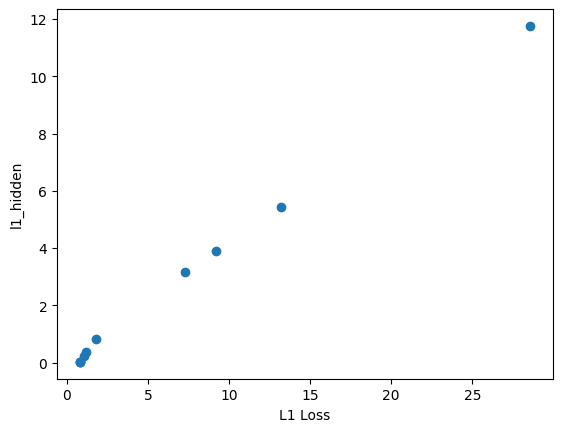

In [11]:
plt.plot(mlp_l1_loss, mlp_l1_hidden_loss, 'o', label="MLP_no_bias")
plt.xlabel("L1 Loss")
plt.ylabel("l1_hidden")